# Analysis Intuition

I wrote my own implementation of the anlaysis that uses python and uproot so that it's easy to look at different snapshots of the analysis and make plots as quickly as possible.

So this notebook shows the implications of each cut of the analysis and makes plots to help me build intuition! (Almost all of the plots in the internal note show the analysis after all the cuts have been applied, so it doesn't give a lot of intuition for what each cut is doing.)

This notebook with two options that let's me run over data or mc so I can also study how these cuts impact the background sculpting.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import uproot

import os
import sys
sys.path.append("../code")
from preprocess import read_tsv, fileDir, yr_short, triggers
from plotting import varEvolution, massPlane

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Which sample to run over

The `subDir` flag steer which sample I'm going to run over, and it will also take care of saving the output figures to separate subdirectories.

The available trigger flags I have are
- 2015_triggers
- HLT_2j35_btight_2j35_L14J15.0ETA25
- HLT_j100_2j55_bmedium
- HLT_j225_bloose
- 2016_triggers
- HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25
- HLT_j100_2j55_bmv2c2060_split
- HLT_j225_bmv2c2060_split

In [2]:
btags = '4b'
physicsSample = 'SMNR'

nFiles = -1 # If we want to run over MORE THAN ONE file, but a subset of the ttl # of events 
trigger ='2016_trigger'

I'm also going to want to use different color maps for the figures to make it super clear later on when looking at thees exactly what I was doing!

In [3]:
c_lead = 'rebeccapurple'
c_subl = 'navy'
nBins = 20

if 'data' in physicsSample:
    subDir = physicsSample
else: 
    if 'triggers' in trigger: 
        subDir = '{}_{}'.format(physicsSample,yr_short[int(trigger[:4])])
    else:
        for year in [2015,2016]:
            if trigger in triggers[year]:
                subDir = '{}_{}'.format(physicsSample,yr_short[year])
        
if 'triggers' in trigger:
    triggerText = trigger.replace("_"," ")
    varRange = (0,200)
else:
    triggerText = trigger
    varRange = (0,400)
        
figDir = "../figures/{}{}/{}".format("2b_" if btags == '2b' else '', subDir, trigger)
    

In [4]:
fDir = "../data/{}_PFlow/".format(physicsSample)

fs = {15 : 0.22, 16 : 0.16}

if physicsSample == 'SMNR':
    
    mc = True
    
    cmap_m  = "BuPu"
    cmap_dr = "RdPu"
    c_evt = 'C4'    
    title = "{} SM NR".format(btags)
    
    fName = "files/df_f_0.22_00*.h5"

elif 'data' in physicsSample:
            
    mc = False
    
    cmap_m  = "YlGnBu"
    cmap_dr = "Blues"
    c_evt = 'k'
    
    yr_tag = int(physicsSample[-2:])
    title = "{} data 20{}".format(btags,yr_tag)

    f = fs[yr_tag]
    fName = "files/df_period?_f_{}_00*.h5".format(f)
    

**Step 1:** Load in the miniNtuples and concatenate them to make a dataframe.

In [5]:
myFiles = fDir + fName
    
cols = ["2015_triggers",
        "HLT_2j35_btight_2j35_L14J15.0ETA25",
        "HLT_j100_2j55_bmedium",
        "HLT_j225_bloose",
        "2016_triggers",
        "HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25",
        "HLT_j100_2j55_bmv2c2060_split",
        "HLT_j225_bmv2c2060_split",
        'm4j', 'mc_sf', 
        'pair0_HC1_m', 'pair1_HC1_m','pair2_HC1_m',
        'pair0_HC2_m', 'pair1_HC2_m','pair2_HC2_m',
        'pair0_HC1_dRjj', 'pair1_HC1_dRjj', 'pair2_HC1_dRjj',
        'pair0_HC2_dRjj', 'pair1_HC2_dRjj', 'pair2_HC2_dRjj',
        'pair0_HC1_pT', 'pair1_HC1_pT', 'pair2_HC1_pT',
        'pair0_HC2_pT', 'pair1_HC2_pT', 'pair2_HC2_pT',
        'pair0_Dhh', 'pair1_Dhh', 'pair2_Dhh',
        'pair0_mask', 'pair1_mask', 'pair2_mask',
        'nValidPairs', 'HC1_vecSum_pT',
        'HC2_vecSum_pT', 'deta_hh', 'Xhh', 'Xwt',
        'resolvedJets_SF_MV2c10_FixedCutBEff_70', 'mcChannelNumber',
        'mcEventWeight', 'HC1_m', 'HC1_pT', 'HC2_m', 'HC2_pT',
        'fourGoodJets', 'MDR', 'MDpT', 'cut_deta_hh', 'cut_Xwt', 'cut_Xhh',
        'nresolvedJets','njets','nbtags', 'resolvedJets_pt', "HCs_pt",
        'j0_idx','j1_idx','j2_idx','j3_idx','eventNumber'] 
   
if nFiles == -1:
    fileList = glob.glob(myFiles)
else:
    fileList = glob.glob(myFiles)[:nFiles]


In [6]:
dfs = []

for i, myFile in enumerate(fileList):

    print('{:>3}. {}'.format(i+1,myFile))
    
    df = pd.read_hdf(myFile,key='df')
    
    if btags == '2b':
        loadMask = df.fourGoodJets & (df.nbtags == 2) & df[trigger]
    else:
        loadMask = df.fourGoodJets & (df.nbtags >= 4) & df[trigger]
    
    # For some reason, I had some duplicate eventNumbers in my 2016 data, so I'm not using
    # eventNumber for concatenation as a work around for this issue
    df['eventNumber'] = df.index
    dfs.append(df.loc[loadMask,cols])
    
miniNtuple = pd.concat(dfs, ignore_index=True)

  1. ../data/SMNR_PFlow/files/df_f_0.22_000009.h5


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


  2. ../data/SMNR_PFlow/files/df_f_0.22_000018.h5
  3. ../data/SMNR_PFlow/files/df_f_0.22_000010.h5
  4. ../data/SMNR_PFlow/files/df_f_0.22_000005.h5
  5. ../data/SMNR_PFlow/files/df_f_0.22_000002.h5
  6. ../data/SMNR_PFlow/files/df_f_0.22_000004.h5
  7. ../data/SMNR_PFlow/files/df_f_0.22_000007.h5
  8. ../data/SMNR_PFlow/files/df_f_0.22_000012.h5
  9. ../data/SMNR_PFlow/files/df_f_0.22_000017.h5
 10. ../data/SMNR_PFlow/files/df_f_0.22_000016.h5
 11. ../data/SMNR_PFlow/files/df_f_0.22_000014.h5
 12. ../data/SMNR_PFlow/files/df_f_0.22_000003.h5
 13. ../data/SMNR_PFlow/files/df_f_0.22_000008.h5
 14. ../data/SMNR_PFlow/files/df_f_0.22_000001.h5
 15. ../data/SMNR_PFlow/files/df_f_0.22_000011.h5
 16. ../data/SMNR_PFlow/files/df_f_0.22_000013.h5
 17. ../data/SMNR_PFlow/files/df_f_0.22_000015.h5
 18. ../data/SMNR_PFlow/files/df_f_0.22_000006.h5


**Step 2:** Use the metadata from the miniNtuple production to get the sum of the mc event weights used to generate this Ntuple.

In [7]:
sum_weights_initial = 0
treeName = "MetaData_EventCount_XhhMiniNtuple"

for myFile in glob.glob(fileDir[physicsSample] + "user.*.MiniNTuple.root"):
    #print(myFile)
    metadata = uproot.open(myFile)[treeName]
    sum_weights_initial += metadata.allvalues[3]

print("sum_weights_initial",sum_weights_initial)

sum_weights_initial 26458.62742272563


**Sanity check:** We were concerned why there are sometimes data events that have a metadata, but no associated miniNtuple, so Max asked me to calculate *how many events are in the metadata*.

In [8]:
noMiniNtuple_sum_weights_initial = 0

for myFile in glob.glob(fileDir[physicsSample] + "user.*.MiniNTuple.root"):
    
    rFile = uproot.open(myFile)
    
    if b"XhhMiniNtuple;1" not in rFile.allkeys():
        print(rFile.allkeys())
        
        metadata = rFile[treeName]
        noMiniNtuple_sum_weights_initial += metadata.allvalues[3]
        
print("sum_weights_initial for root files w/o a miniNtuple",noMiniNtuple_sum_weights_initial)

sum_weights_initial for root files w/o a miniNtuple 0


In [9]:
metadata.allvalues

array([    0.        , 60000.        , 60000.        ,  1625.07373755,
        1625.07373755,   288.72101258,   288.72101258,     0.        ])

In [10]:
metadata.values

array([60000.        , 60000.        ,  1625.07373755,  1625.07373755,
         288.72101258,   288.72101258])

**Step 3:** For the sample weight, we also need to include
- the luminosity to normalize to
- the cross section
- the k-factor
- the generator filter efficiency

I can derive the sample weight for the event using the mc channel number.

In [11]:
assert miniNtuple.mcChannelNumber.min() == miniNtuple.mcChannelNumber.min()
mcChannelNumber = np.unique(miniNtuple.mcChannelNumber)[0]

In [12]:
db_entry = read_tsv()

In [13]:
# Normalize to the 2015 data rn, but it doesn't have a big impact for this study
lumi = 3.2

if mc:

    chanNums = np.unique(miniNtuple.mcChannelNumber)
    i_mc = chanNums[0].astype(int)

    sample_weight = lumi 
    sample_weight *= db_entry.loc[i_mc,"xsec"] 
    sample_weight *= db_entry.loc[i_mc,"k_factor"] 
    sample_weight *= db_entry.loc[i_mc,"gen_filter_eff"] 
    sample_weight /= sum_weights_initial
    
    miniNtuple['mc_sf'] *= sample_weight


In [14]:
miniNtuple.columns

Index(['2015_triggers', 'HLT_2j35_btight_2j35_L14J15.0ETA25',
       'HLT_j100_2j55_bmedium', 'HLT_j225_bloose', '2016_triggers',
       'HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25',
       'HLT_j100_2j55_bmv2c2060_split', 'HLT_j225_bmv2c2060_split', 'm4j',
       'mc_sf', 'pair0_HC1_m', 'pair1_HC1_m', 'pair2_HC1_m', 'pair0_HC2_m',
       'pair1_HC2_m', 'pair2_HC2_m', 'pair0_HC1_dRjj', 'pair1_HC1_dRjj',
       'pair2_HC1_dRjj', 'pair0_HC2_dRjj', 'pair1_HC2_dRjj', 'pair2_HC2_dRjj',
       'pair0_HC1_pT', 'pair1_HC1_pT', 'pair2_HC1_pT', 'pair0_HC2_pT',
       'pair1_HC2_pT', 'pair2_HC2_pT', 'pair0_Dhh', 'pair1_Dhh', 'pair2_Dhh',
       'pair0_mask', 'pair1_mask', 'pair2_mask', 'nValidPairs',
       'HC1_vecSum_pT', 'HC2_vecSum_pT', 'deta_hh', 'Xhh', 'Xwt',
       'resolvedJets_SF_MV2c10_FixedCutBEff_70', 'mcChannelNumber',
       'mcEventWeight', 'HC1_m', 'HC1_pT', 'HC2_m', 'HC2_pT', 'fourGoodJets',
       'MDR', 'MDpT', 'cut_deta_hh', 'cut_Xwt', 'cut_Xhh', 'nresolvedJets',
       'njet

## Step 1: Four $p_T > 40$ GeV, $\eta < 2.5$ b-tagged jets

As soon as I have four b-tagged jets, I can make the $m_{4j}$ distribution. For the flow of this notebook, I'm going to keep track of the masks for each analysis cut that I'm making to avoid duplicating too much code. 


**Trigger first implementation**

Plan: Let tmask be a boolean mask that is always True if `triggerFirst` is False. Otherwise tmask will correspon to the `trigger` column of the miniNtuple df.

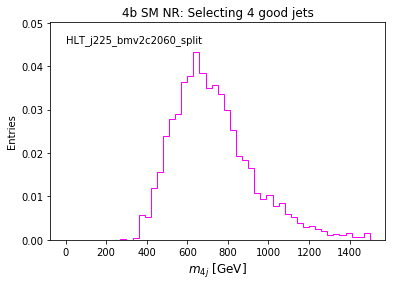

In [15]:
# Note - this mask is now *trivial* b/c I'm only loading in data that passes this cut
mask = miniNtuple.fourGoodJets 

masks = [mask]
colors = ['magenta']
labels = ['4 b-jets $p_T > 40$ GeV, $|\eta| < 2.5$']

m4j_range = (0,1500)
xlabel = '$m_{4j}$ [GeV]'

baseFigName = 'fourGoodJets'
my_title = title + ': Selecting 4 good jets'
varEvolution(miniNtuple, 'm4j', masks, colors, labels=[], 
             var_range=m4j_range,xlabel=xlabel,
             title=my_title, 
             figDir=figDir, baseFigName=baseFigName,
             text=triggerText,ratio=False)

**Look at the mass plane just after selecting these 4 jets**

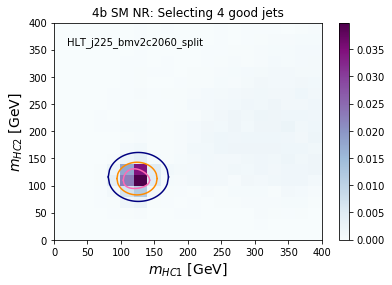

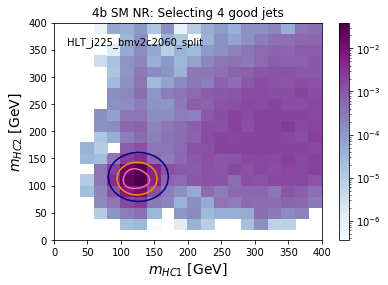

In [16]:
m1s = np.concatenate([miniNtuple.loc[mask,'pair{}_HC1_m'.format(i)] for i in range(3)],axis=0)
m2s = np.concatenate([miniNtuple.loc[mask,'pair{}_HC2_m'.format(i)] for i in range(3)],axis=0)

ws = np.concatenate([miniNtuple.loc[mask,'mc_sf']]*3,axis=0)/3

massPlane(m1s, m2s, ws, cmap_m, nBins=nBins, varRange=varRange,  title=my_title,
          figDir=figDir, baseFigName=baseFigName, text=triggerText)


Ok, for the signal after you select the 4 b-tagged jets, since we actually have a resonance, we see a peak at around the Higgs mass.

## Step 2

Mass dependent $\Delta R$ cut. 

Since $\Delta R$ between the constitents acts as a proxy for the mass, I think it's also important to keep an eye on how we're sculpting this distribution as well!


In [17]:
# For overlaying these curves!
m4j_min, m4j_max = 1, 1250 # GeV
m4j = np.linspace(m4j_min, m4j_max) 

Rmin_lead = 360 / m4j - 0.5
Rmax_lead = 653 / m4j + 0.475

Rmin_subl = 235 / m4j
Rmax_subl = 875 / m4j + 0.35

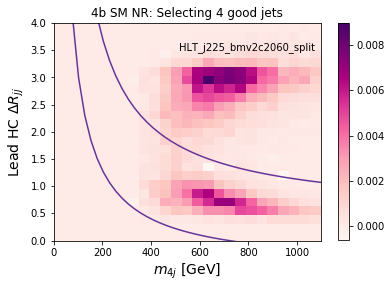

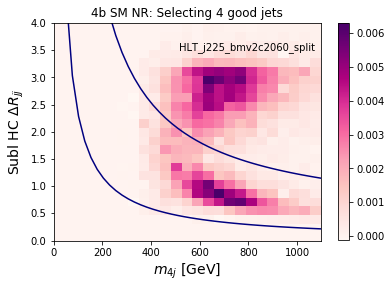

In [18]:
m4j_x3 = np.concatenate([miniNtuple.loc[mask,'m4j']]*3,axis=0)

dRjj1s = np.concatenate([miniNtuple.loc[mask,'pair{}_HC1_dRjj'.format(i)] for i in range(3)],axis=0)
dRjj2s = np.concatenate([miniNtuple.loc[mask,'pair{}_HC2_dRjj'.format(i)] for i in range(3)],axis=0)

for dRjj,HC_ID, dRmin, dRmax, c, i in zip([dRjj1s,dRjj2s],['Lead','Subl'],
                                          [Rmin_lead,Rmin_subl],[Rmax_lead,Rmax_subl],
                                          [c_lead,c_subl],[1,2]):

    plt.figure()
    plt.hist2d(m4j_x3, dRjj,
               bins=25,range=[(0,1100),(0,4)],
               cmap=cmap_dr,weights=ws)
    plt.colorbar()

    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(HC_ID+' HC $\Delta R_{jj}$',fontsize=14)

    plt.title(my_title)

    # Overlay the curves that we're cutting on for dRjj
    plt.plot(m4j,dRmin, c)
    plt.plot(m4j,dRmax, c)
    
    plt.text(1075,3.5,triggerText,horizontalalignment='right')
    
    plt.savefig('{}/{}_HC{}_dRjj_m4j.pdf'.format(figDir,baseFigName,i))
    
plt.show()

This looks spread out right now, because we're plotting all three of the possible combinations, but it's cool because you can *visually see* which combinations will get rejected by applying this cut!

**Implementation**

My miniNtuple has columns `pair0_mask`, `pair1_mask`, and `pair2_mask` which are booleans which store whether or not the event pair is valid for this combination of masses.

Since I want to keep track of the possible pairings for each event, I don't want to use flattened arrays yet.


In [19]:
hc1_cols = ['pair{}_HC1_dRjj'.format(i) for i in range(3)]
hc2_cols = ['pair{}_HC2_dRjj'.format(i) for i in range(3)]

lead_dR_arr = miniNtuple.loc[mask,hc1_cols].values
subl_dR_arr = miniNtuple.loc[mask,hc2_cols].values

pm_cols = ['pair{}_mask'.format(i) for i in range(3)]
pair_mask = miniNtuple.loc[mask,pm_cols].values

**Number of possible pairings**

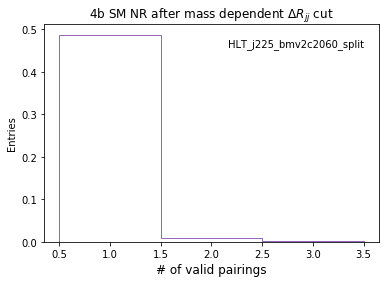

In [20]:
baseFigName='MDR'
my_title = title + ' after mass dependent $\Delta R_{jj}$ cut'

mask = miniNtuple.MDR # & miniNtuple.tmask

plt.hist(miniNtuple.nValidPairs[mask],3,(0.5,3.5),color=c_evt,histtype='step',
         weights=miniNtuple.mc_sf[mask])
plt.xlabel('# of valid pairings',fontsize=12)
plt.ylabel('Entries')
plt.title(my_title)

_,ymax = plt.ylim()
plt.text(3.5,0.9*ymax,triggerText,horizontalalignment='right')

plt.savefig('{}/{}_validPairings.pdf'.format(figDir,baseFigName))
plt.show()

In [21]:
n,_ = np.histogram(miniNtuple.nValidPairs[mask],3,(0.5,3.5),
                     weights=miniNtuple.mc_sf[mask],density=True)
n

array([0.97555879, 0.0202023 , 0.00423891])

So this cut does a very good job at isolating our SM signal.

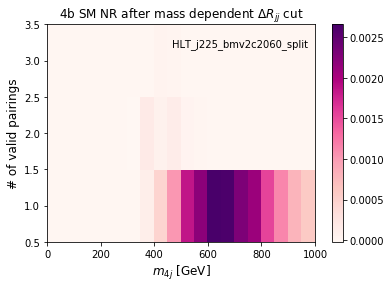

In [22]:
plt.hist2d(miniNtuple.m4j[mask],
           miniNtuple.nValidPairs[mask], bins=(20,3),range=((0,1000),(0.5,3.5)), 
           cmap=cmap_dr,normed=True,
           weights=miniNtuple.mc_sf[mask])
plt.xlabel('$m_{4j}$ [GeV]',fontsize=12)
plt.ylabel('# of valid pairings',fontsize=12)
plt.colorbar()
plt.title(my_title)

plt.text(975,3.2,triggerText,horizontalalignment='right')

plt.savefig('{}/{}_validPairings_vs_m4j.pdf'.format(figDir,baseFigName))
plt.show()

**$m_{4j}$ versus # of additional jets**

In the internal note, they say that the sculpting in the low mass validation region is due to the number of additional jets, and demonstrate this by showing the # of additional jets vs $m_{4j}$ plot, so for completeness, I'm going to show this as well.

<img src='../figures/data_16/intNote_fourGoodJets_additionalJets_vs_m4j.png' width='300' />


I'm not really sure how I should plot the # of additional jets, I could
1. Look at the nresolvedJets (the # of jets from XhhCommon)
2. Look at njets, the # of jets with $p_T$ > 40 GeV and $|\eta|$ < 2.5
3. Look at nbjets, the # of b-jets with $p_T$ > 40 GeV and $\eta$ < 2.5

**Plan:** Let's look at *all* of them!



*But after iterating, this is* not at all *an apples to apples comparison, because the plot above was for the LMVR, while I've been making them for the full massplane.*

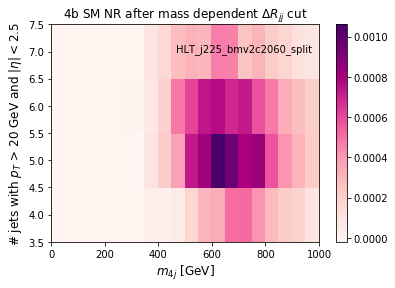

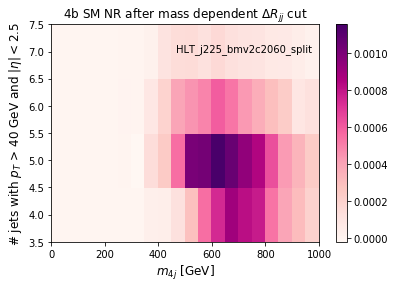

In [23]:
cols = ['nresolvedJets','njets']#,'nbtags']
ylabels = ['# jets with $p_T$ > 20 GeV and $|\eta| < 2.5$',
           '# jets with $p_T$ > 40 GeV and $|\eta| < 2.5$']

for col, ylabel in zip(cols,ylabels):
    
    plt.hist2d(miniNtuple.loc[mask,'m4j'],
               miniNtuple.loc[mask,col], bins=(20,4),range=((0,1000),(3.5,7.5)), 
               cmap=cmap_dr,normed=True,
               weights=miniNtuple.loc[mask,'mc_sf'])
    plt.xlabel('$m_{4j}$ [GeV]',fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.colorbar()
    plt.title(my_title)

    plt.text(975,7,triggerText,horizontalalignment='right')

    plt.savefig('{}/{}_{}_vs_m4j.pdf'.format(figDir,col,baseFigName))
    plt.show() 
    

Ok, I think the most interesting thing to me about this plot rn is for the signal, we almost never have events with multiple b-tags... good to know, but it will be interesting to check the interplay between b-tagging and $p_T$ for lower $p_T$ as well.

**2d mass plane**

The question that we're trying to answer is how this pairing sculpts the mass distribution. So to answer this question, I want to plot the 2d mass plane again.

There's a few choices that I have to make this plot:
1. I could modify the weights to give less weight to the events that have fewer valid pairings. 
2. I could plot all the pairings on equal footing
3. I could also just make different distributions for 1, 2, and 3 valid pairings?

In [24]:
m1_cols = ['pair{}_HC1_m'.format(i) for i in range(3)]
m2_cols = ['pair{}_HC2_m'.format(i) for i in range(3)]

# Note, the pair_mask will implement the MDR cut, and I need to use the
# fourGoodJets mask so the variable and mask are the same shape
# m1_MDR = miniNtuple.loc[miniNtuple.fourGoodJets & miniNtuple.tmask,m1_cols].values[pair_mask]
# m2_MDR = miniNtuple.loc[miniNtuple.fourGoodJets & miniNtuple.tmask,m2_cols].values[pair_mask]

m1_MDR = miniNtuple[m1_cols].values[pair_mask]
m2_MDR = miniNtuple[m2_cols].values[pair_mask]

In [25]:
# Note: nValidParis will be 0 for cases where there are no valid pairs, but
# I'll be masking these values anyways, to I don't have to worry about the warning 
base_w = np.nan_to_num(miniNtuple.mc_sf / miniNtuple.nValidPairs)
#base_w = base_w[miniNtuple.fourGoodJets & miniNtuple.tmask]

ws_MDR = np.vstack([base_w]*3).T
ws_MDR = ws_MDR[pair_mask]


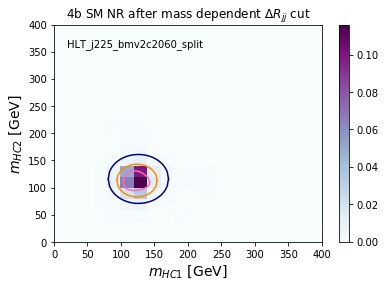

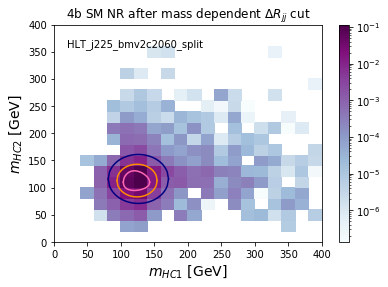

In [26]:
massPlane(m1_MDR, m2_MDR, ws_MDR, cmap_m, nBins=nBins, varRange=varRange, title=my_title,
          figDir=figDir, baseFigName=baseFigName, text=triggerText)

**Version 2 of the plot:** Plot all the valid pairs, w/o doing this funky thing with the weights.

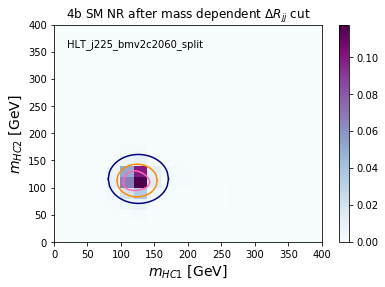

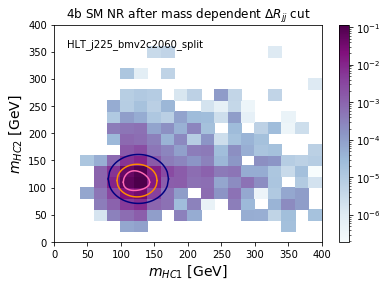

In [27]:
ws_MDR_allEvts = np.vstack([miniNtuple.mc_sf]*3).T
ws_MDR_allEvts = ws_MDR_allEvts[pair_mask]

massPlane(m1_MDR, m2_MDR, ws_MDR_allEvts, cmap_m, nBins=nBins, varRange=varRange, title=my_title,
          figDir=figDir, baseFigName=baseFigName,tag='_allEvts', 
          text=triggerText)


In [28]:
pair_cols = ['pair{}_mask'.format(i) for i in range(3)]

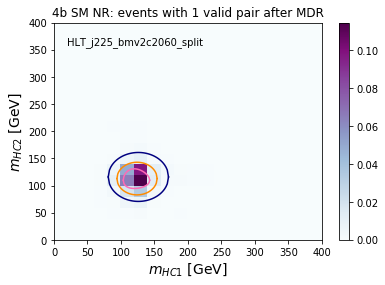

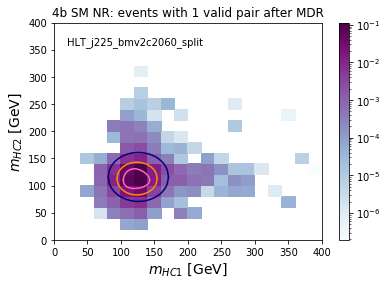

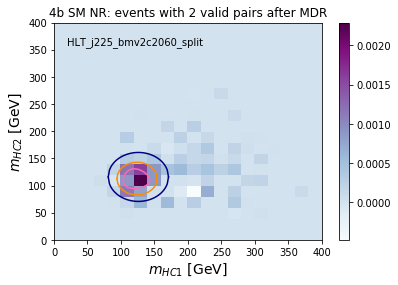

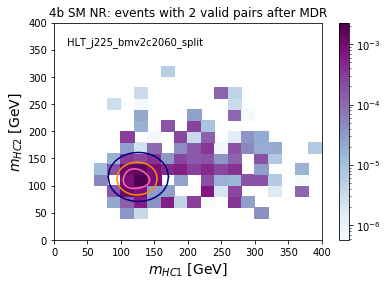

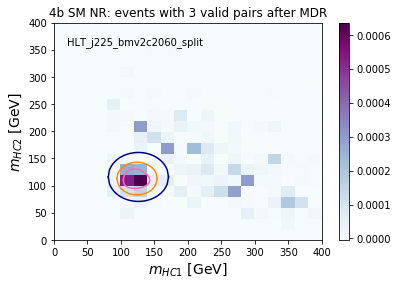

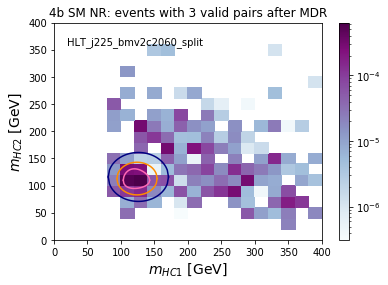

In [29]:
for nPairs in [1,2,3]:
    
    # Get the masses
    mask_pi = mask & (miniNtuple.nValidPairs == nPairs)
    pair_mask = miniNtuple.loc[mask_pi,pair_cols].values
    
    m1_npi = miniNtuple.loc[mask_pi,m1_cols].values
    m2_npi = miniNtuple.loc[mask_pi,m2_cols].values
    
    w_pi = miniNtuple.loc[mask_pi,'mc_sf'].values.reshape(-1,1)*np.ones_like(m1_npi)

    my_title = title + ': events with {} valid pair{} after MDR'.format(nPairs,'' if nPairs==1 else 's')

    massPlane(m1_npi[pair_mask], m2_npi[pair_mask], w_pi[pair_mask], cmap_m,
              nBins=nBins, varRange=varRange, 
              title=my_title, figDir=figDir, 
              baseFigName=baseFigName,
              tag='_{}validPair'.format(nPairs), 
              text=triggerText)


**Sanity check** Ok, I think I should sanity check super quickly that these masking and concatenation functions are doing what I think they should be!

In [30]:
x = np.array([[1,2,3],[4,5,6]])
pair_mask = np.array([[True,False,True],[True,True,False]])

ws = np.array([.1,.5])

In [31]:
x[pair_mask]

array([1, 3, 4, 5])

In [32]:
(ws.reshape(-1,1) * np.ones_like(x))[pair_mask]

array([0.1, 0.1, 0.5, 0.5])

In [33]:
masks.append(miniNtuple.MDR) # & miniNtuple.tmask)
colors.append('C0')
labels.append('Mass dependent $\Delta R_{jj}$ cut')

In [34]:
rlabel = '1 / 4 good jets'

../code/plotting.py:72: RuntimeWarning: invalid value encountered in true_divide
  ax2.scatter(x, n / n0, color=c) #, marker=marker, label=label)


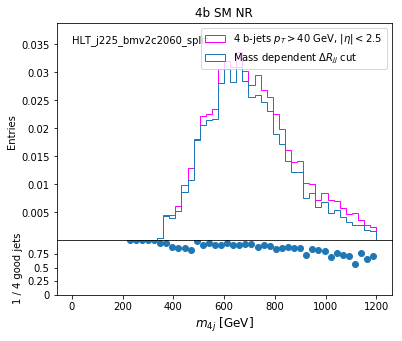

In [35]:
varEvolution(miniNtuple, 'm4j', masks, colors, labels=labels, 
             var_range=(0,1200),xlabel=xlabel, title=title, 
             figDir=figDir, baseFigName=baseFigName,text=triggerText,
             ratio=True,rlabel=rlabel)

- This MDR cut is not eliminating a lot of signal events.
- This MDR cut is very good at eliminating the background events, particularly for the high $m_{4j}$ values.

**Follow-up:** Look at $m_{4j}$ in slices of the # of pairings. Based on the 2d plots above, I expect the more valid pairings, the lower the invariant mass.


*Oh, could this be why the SM signal has less valid pairings?*

In [36]:
#pair_masks =[miniNtuple.fourGoodJets & (miniNtuple.nValidPairs == nPairs) & miniNtuple.tmask for nPairs in range(4)]

pair_masks =[(miniNtuple.nValidPairs == nPairs) for nPairs in range(4)]
pair_colors = ['grey','C6','C4','C2']
pair_labels = ['{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's') for nPairs in range(4)]

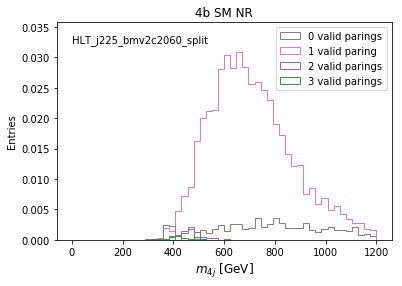

In [37]:
varEvolution(miniNtuple, 'm4j', pair_masks, pair_colors, labels=pair_labels, 
             var_range=(0,1200), xlabel=xlabel, title=title, 
             figDir=figDir, baseFigName='nValidPairs',text=triggerText)

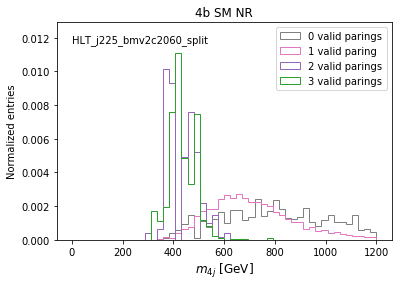

In [38]:
varEvolution(miniNtuple, 'm4j', pair_masks, pair_colors, labels=pair_labels, 
             var_range=(0,1200), density=True, xlabel=xlabel, title=title, 
             figDir=figDir, baseFigName='nValidPairs', tag='_norm',text=triggerText)

Also, it's interesting to look at the opening angles between the jets for the different analysis categories.

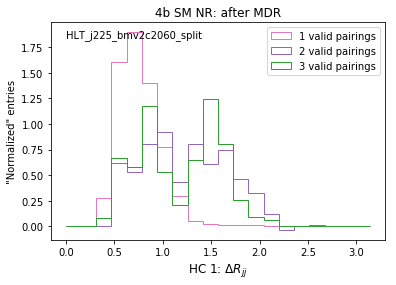

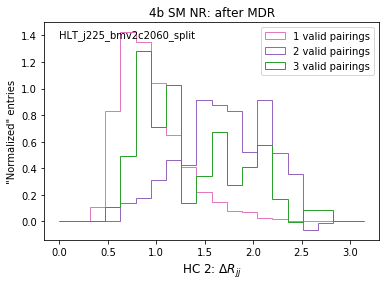

In [39]:
for HC_idx, hc_cols in zip([1,2],[hc1_cols,hc2_cols]): 

    plt.figure()
    
    for nPairs,c in zip([1,2,3],['C6','C4','C2']):

        # Get the masses
        mask_pi = mask & (miniNtuple.nValidPairs == nPairs)
        pair_mask = miniNtuple.loc[mask_pi,pair_cols].values

        dRjj = miniNtuple.loc[mask_pi,hc_cols].values

        w_pi = np.concatenate(miniNtuple.loc[mask_pi,['mc_sf']*nPairs].values)

        plt.hist(dRjj[pair_mask],20,(0,np.pi),weights=w_pi, density=True, color=c,
                 label='{} valid pairings'.format(nPairs),histtype='step')
    
    _,ymax = plt.ylim()
    plt.text(0,0.925*ymax,triggerText)
    
    plt.title(title + ': after MDR')
    plt.xlabel('HC {}: '.format(HC_idx) + '$\Delta R_{jj}$',fontsize=12)
    plt.ylabel('"Normalized" entries')
    plt.legend()
    plt.savefig('{}/MDR_HC{}_dRjj_validPairs.pdf'.format(figDir,HC_idx),bbox_inches='tight')

See whether the signal and background follow the $\Delta R_{jj} < \frac{2 m_H }{ p_T }$ curves.

In [40]:
pt1_cols = ['pair{}_HC1_pT'.format(i) for i in range(3)]
pt2_cols = ['pair{}_HC1_pT'.format(i) for i in range(3)]

pt = np.linspace(0.1,750)
mH = 125

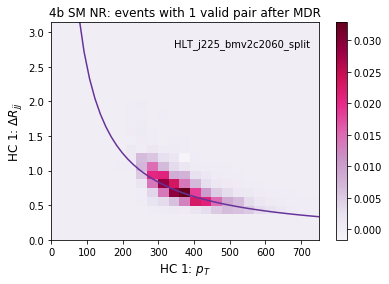

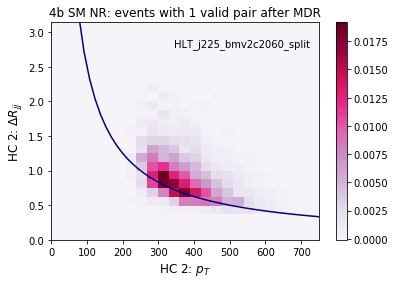

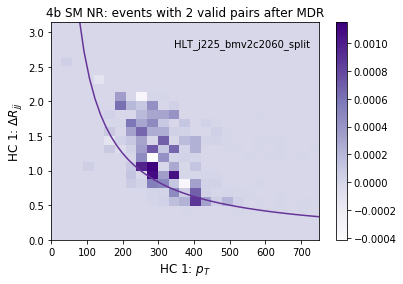

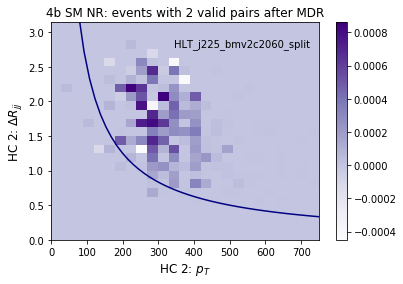

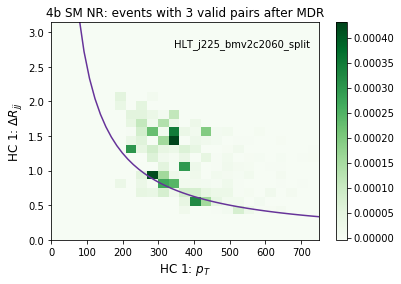

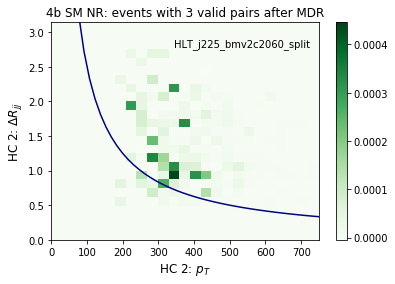

In [41]:
for nPairs, cmap in zip([1,2,3],['PuRd','Purples','Greens']):

    mask_pi = mask & (miniNtuple.nValidPairs == nPairs)

    for HC_idx, hc_cols, pt_cols, c in zip([1,2],[hc1_cols,hc2_cols],[pt1_cols,pt2_cols],[c_lead,c_subl]): 

        plt.figure()

        pair_mask = miniNtuple.loc[mask_pi,pair_cols].values

        dRjj = miniNtuple.loc[mask_pi,hc_cols].values
        pts = miniNtuple.loc[mask_pi,pt_cols].values

        w_pi = np.concatenate(miniNtuple.loc[mask_pi,['mc_sf']*nPairs].values)

        plt.hist2d(pts[pair_mask],dRjj[pair_mask],
                   25,[(0,750),(0,np.pi)], weights=w_pi, cmap=cmap)
        plt.plot(pt, 2*mH /pt, c)

        plt.text(725,2.8,triggerText,horizontalalignment='right')

        my_title = title + ': events with {} valid pair{} after MDR'.format(nPairs,'' if nPairs==1 else 's')
        plt.title(my_title)
        plt.colorbar()
        plt.xlabel('HC {}: '.format(HC_idx) + '$p_T$',fontsize=12)
        plt.ylabel('HC {}: '.format(HC_idx) + '$\Delta R_{jj}$',fontsize=12)

        plt.savefig('{}/MDR_HC{}_dRjj_vs_pt_{}validPairs.pdf'.format(figDir,HC_idx,nPairs),bbox_inches='tight')

So, part of the intuition that we're starting to build up is for signal, this multiple valid pairings category is due to *recoil* off of an ISR jet. I've investigated this already in `Pairing-Kinematics`, but I'm going to look at it here as well so that I can see if something similar is happening for the background or not.

In [42]:
# singleEvts = 0
# doubleEvts = 0

# for ievt, indices in miniNtuple.loc[miniNtuple.MDR,['j{}_idx'.format(i) for i in range(4)]].iterrows():
    
#     try:
#         if (miniNtuple.loc[ievt,'nresolvedJets'] == 4):
#             pass
#         singleEvts += 1
#     except ValueError:
#         doubleEvts += 1

# print("singleEvts",singleEvts)
# print("doubleEvts",doubleEvts)

In [43]:
unique_arr, counts = np.unique(miniNtuple.eventNumber, return_counts=True)

In [44]:
unique_arr.shape

(32003,)

In [45]:
counts[counts != 1]

array([], dtype=int64)

In [46]:
miniNtuple['lead_nonSel_pt'] = 0 

for ievt, indices in miniNtuple.loc[miniNtuple.MDR,['j{}_idx'.format(i) for i in range(4)]].iterrows():

    if miniNtuple.loc[ievt,'nresolvedJets'] == 4:
        continue

    miniNtuple.loc[ievt,'lead_nonSel_pt'] = [pt for i, pt in enumerate(miniNtuple.loc[ievt,'resolvedJets_pt']) \
                                             if i not in list(indices)][0] 

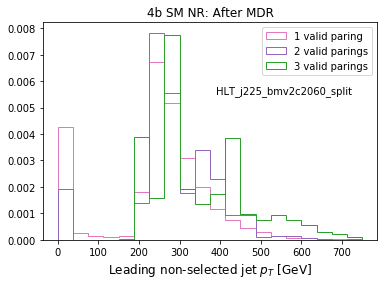

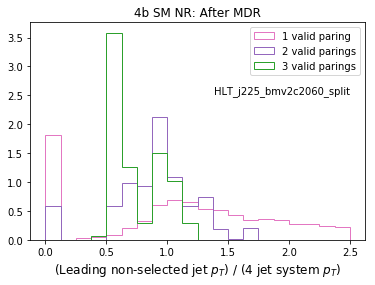

In [47]:
plt.figure()
for nPairs,c in zip([1,2,3],['C6','C4','C2']):

    mask_pi = mask & (miniNtuple.nValidPairs == nPairs)
    label = '{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's')

    plt.hist(miniNtuple.loc[mask_pi,'lead_nonSel_pt'],
             bins=20, range=(0,750), label=label,
             color=c, histtype='step', density=True,
             weights=miniNtuple.loc[mask_pi,'mc_sf'])

ylim = plt.ylim()
plt.text(725,0.675*ylim[1],triggerText,horizontalalignment='right')

plt.xlabel('Leading non-selected jet $p_T$ [GeV]',fontsize=12)
plt.legend()
plt.title(title+': After MDR') 
plt.savefig('{}/MDR_lead_nonSelJet_pt.pdf'.format(figDir))


plt.figure()
for nPairs,c in zip([1,2,3],['C6','C4','C2']):

    mask_pi = mask & (miniNtuple.nValidPairs == nPairs)
    label = '{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's')

    plt.hist(miniNtuple.loc[mask_pi,'lead_nonSel_pt'] / miniNtuple.loc[mask_pi,'HCs_pt'],
             bins=20, range=(0,2.5), label=label,
             color=c, histtype='step', density=True,
             weights=miniNtuple.loc[mask_pi,'mc_sf'])

ylim = plt.ylim()
plt.text(2.5,0.675*ylim[1],triggerText,horizontalalignment='right')
    
plt.xlabel('(Leading non-selected jet $p_T$) / (4 jet system $p_T$)',fontsize=12)
plt.legend()
plt.title(title+': After MDR')  
plt.savefig('{}/MDR_lead_nonSelJet_pt_over_HC_pt.pdf'.format(figDir))

plt.show()

## Step 3: Apply the pairing algorithm to define the HC pairing

The formula for $D_{hh}$ from [the paper](https://arxiv.org/abs/1804.06174) is 

$$D_{hh} = \frac{|m_{2j}^{lead} - \frac{120}{110} m_{2j}^{subl}|}{\sqrt{1 + (\frac{120}{110})^2}}$$

So the good news is that since I've already stored the masses for all of the HCs, I'm setup to compute this right now!

**Note:** After this step, I can compare with what Beojean has in his framework!

**Visualizing what this cut is doing**

Let's plot the $D_{hh}$ distribution for the different numbers of possible pairings to get an intuition for what this looks like, and how it might be sculpting our results.

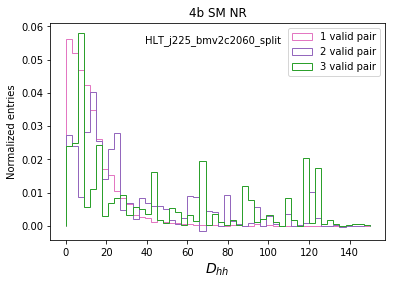

In [48]:
myRange=(0,150)

dhh_cols = ['pair{}_Dhh'.format(pair) for pair in range(3)]

for i,c in zip([1,2,3],pair_colors[1:]):
        
    mask_pi = mask & (miniNtuple.nValidPairs == i)
    pair_mask = miniNtuple.loc[mask_pi,pair_cols].values
    
    dhh_npi = miniNtuple.loc[mask_pi,dhh_cols].values
    w_pi = miniNtuple.loc[mask_pi,'mc_sf'].values.reshape(-1,1)*np.ones_like(dhh_npi)
  
    plt.hist(dhh_npi[pair_mask],bins=50,range=myRange,
             color=c, histtype='step',
             label='{} valid pair'.format(i), density=True, 
             weights=w_pi[pair_mask])
    
plt.title(title)
plt.xlabel('$D_{hh}$',fontsize=14)
plt.ylabel('Normalized entries')
plt.legend()

xlim = plt.xlim()
ylim = plt.ylim()
plt.text(0.675*xlim[1],0.9*ylim[1],triggerText,horizontalalignment='right')

plt.savefig('{}/{}_Dhh.pdf'.format(figDir,baseFigName))
plt.show()

- I decided to normalize all of the histograms so I wasn't overwhelmed by the events with only one possible pairing.
- I thought it seemed interesting that the distribution with 3 valid pairs was quite a bit more spread out than I was anticipating. I think it will be interesting to see how this plot evolves with more stats!


In [49]:
np.min(dhh_npi),np.max(dhh_npi)

(0.05910538265281884, 348.4193819772784)

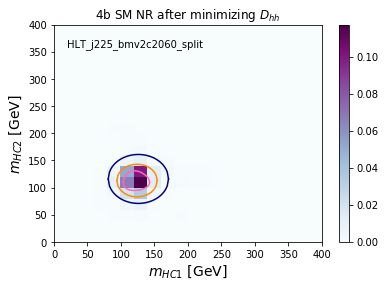

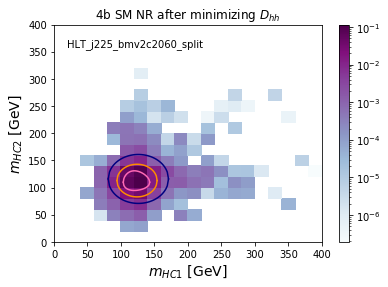

In [50]:
massPlane(miniNtuple.loc[mask,'HC1_m'], 
          miniNtuple.loc[mask,'HC2_m'],
          miniNtuple.loc[mask,'mc_sf'],
          cmap_m, nBins=nBins, varRange=varRange,  
          title=title+' after minimizing $D_{hh}$', 
          figDir=figDir, baseFigName='dhh', text=triggerText)

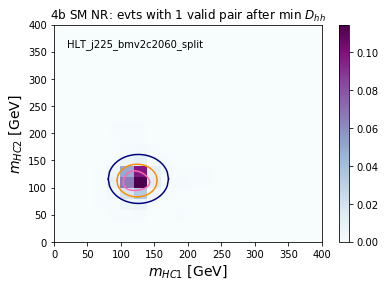

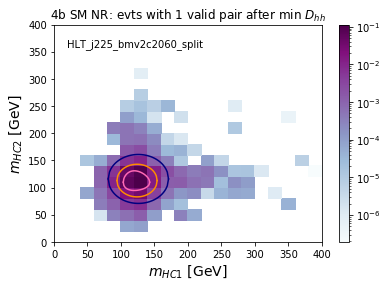

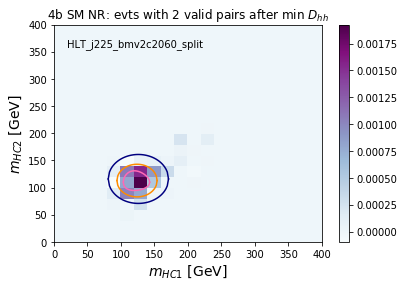

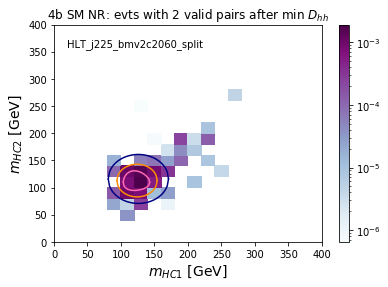

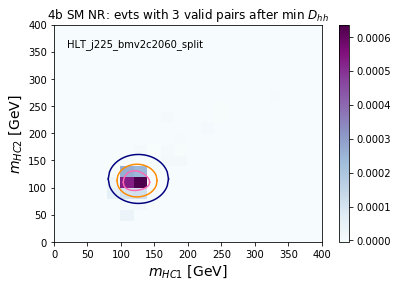

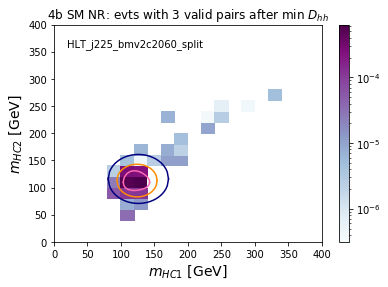

In [51]:
for nPairs in [1,2,3]:
    
    my_title = title + ': evts with {} valid pair{}'.format(nPairs,'' if nPairs==1 else 's')
    my_title += ' after min $D_{hh}$'
    
    mask_pi = mask & (miniNtuple.nValidPairs == nPairs)
    
    massPlane(miniNtuple.loc[mask_pi,'HC1_m'], 
              miniNtuple.loc[mask_pi,'HC2_m'],
              miniNtuple.loc[mask_pi,'mc_sf'],
              cmap_m, nBins=nBins, varRange=varRange, title=my_title, 
              figDir=figDir, baseFigName='dhh', 
              tag='_{}validPair'.format(nPairs),
              text=triggerText)

## Step 4: Mass dependent $p_T$ cut

Now that we have HCs, we can use their $p_T$ spectra to discriminate between signal and background. 

$$p_T^{lead} > 0.5 m_{4j} - 103 \text{ GeV}$$
$$p_T^{subl} > 0.33 m_{4j} - 73 \text{ GeV}$$

**Note: This is the only point in the analysis where the HCs are sorted by the vector sum of the $p_T$ instead of the scalar sum of the consituent jet $p_T$s**.  To make this cut easy to analyze offline, I stored the $p_T$s HCs ordered by the vector sum in the datafame.

Also note that to get good agreement with the cutflow, I used more sig figs in the $p_T$ cut definitions, but I'm just going to plot the equations above since this plot is really just to build my intuition.


In [52]:
pT_lead = 0.5 * m4j - 103
pT_subl = 0.33 * m4j - 73

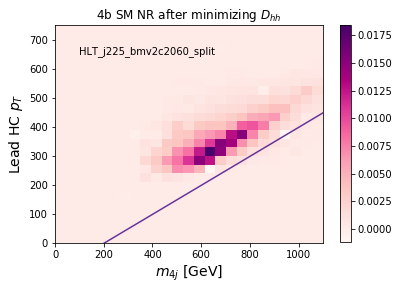

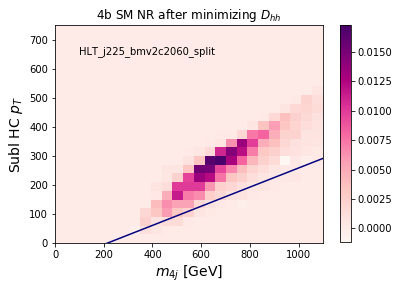

In [53]:
for HC_ID, pTmin, c, i in zip(['Lead','Subl'],[pT_lead,pT_subl],
                              [c_lead,c_subl],[1,2]):

    plt.figure()
    HC_key = 'HC{}_vecSum_pT'.format(i)
    plt.hist2d(miniNtuple.loc[mask,'m4j'], 
               miniNtuple.loc[mask,HC_key],
               bins=25,range=[(0,1100),(0,750)],cmap=cmap_dr,
               weights=miniNtuple.loc[mask,'mc_sf'])
    plt.colorbar()

    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(HC_ID+' HC $p_T$',fontsize=14)

    plt.title(title+' after minimizing $D_{hh}$')

    # Overlay the curves that we're cutting on for dRjj
    plt.plot(m4j,pTmin, c)
    
    plt.text(100,650,triggerText)
    
    plt.savefig('{}/dhh_HC{}_vecSum_pT_m4j.pdf'.format(figDir,i))
    
plt.show()

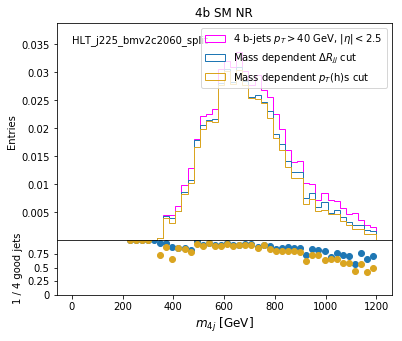

In [54]:
baseFigName='MDpT'

mask = miniNtuple.MDpT #& miniNtuple.tmask
masks.append(mask)
colors.append('goldenrod')
labels.append('Mass dependent $p_T$(h)s cut')

varEvolution(miniNtuple, 'm4j', masks, colors, labels=labels, 
             var_range=(0,1200),xlabel=xlabel, title=title, 
             figDir=figDir, baseFigName=baseFigName,text=triggerText,
             ratio=True,rlabel=rlabel)

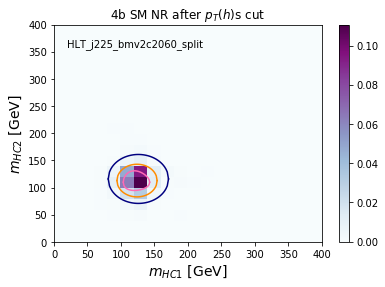

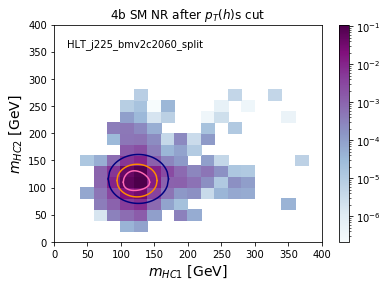

In [55]:
massPlane(miniNtuple.loc[mask,'HC1_m'], 
          miniNtuple.loc[mask,'HC2_m'],
          miniNtuple.loc[mask,'mc_sf'],
          cmap_m, nBins=nBins, varRange=varRange, 
          title=title+' after $p_T(h)$s cut', 
          figDir=figDir, baseFigName=baseFigName, text=triggerText)

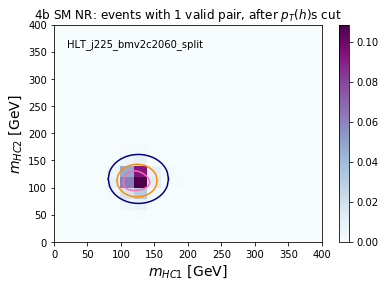

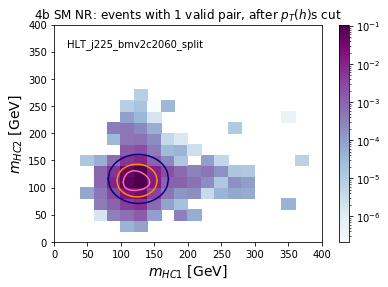

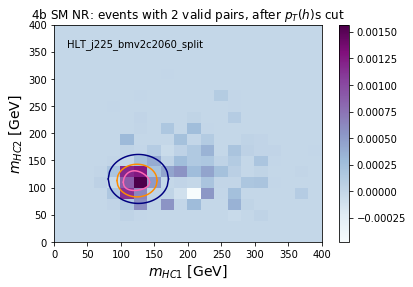

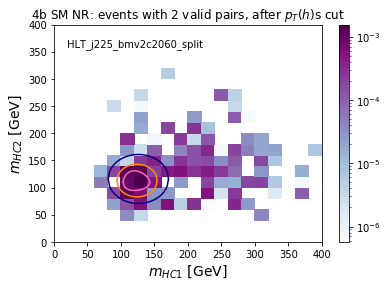

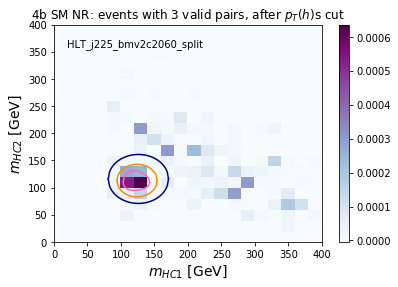

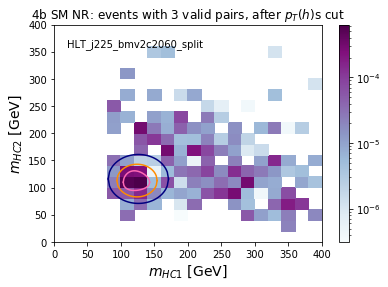

In [56]:
for nPairs in [1,2,3]:
    
    # Get the masses
    mask_pi = mask & (miniNtuple.nValidPairs == nPairs)
    pair_mask = miniNtuple.loc[mask_pi,pair_cols].values
    
    m1_npi = miniNtuple.loc[mask_pi,m1_cols].values
    m2_npi = miniNtuple.loc[mask_pi,m2_cols].values
    
    w_pi = miniNtuple.loc[mask_pi,'mc_sf'].values.reshape(-1,1)*np.ones_like(m1_npi)

    my_title = title + ': events with {} valid pair{}, after $p_T(h)$s cut'.format(nPairs,'' if nPairs==1 else 's')
    
    massPlane(m1_npi[pair_mask], m2_npi[pair_mask], w_pi[pair_mask], cmap_m,
              nBins=nBins, varRange=varRange, 
              title=my_title, 
              figDir=figDir, baseFigName=baseFigName,
              tag='_{}validPair'.format(nPairs), 
              text=triggerText)

## Step 5: $|\Delta \eta_{hh}| < 1.5$

So the claim from the paper is that this helps minimize the QCD background, and I think this also makes sense because we expect the SM NR signal to be more central.

Also note, the CMS analysis was performed in bins of $\Delta \eta_{hh}$, so this is something that we could think about as well.


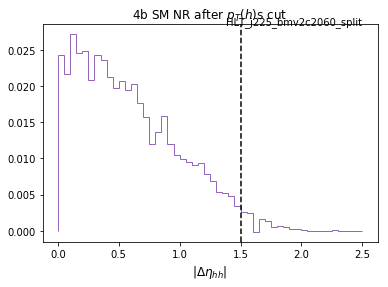

In [57]:
plt.hist(miniNtuple.loc[mask,'deta_hh'],50,(0.,2.5),
         color=c_evt,histtype='step',
         weights=miniNtuple.loc[mask,'mc_sf'])
plt.xlabel('$|\Delta\eta_{hh}|$',fontsize=12)
plt.title(title+' after $p_T(h)$s cut')

ylim = plt.ylim()
plt.plot([1.5,1.5],(ylim[0],1.1*ylim[1]),'k--')
plt.ylim(ylim)

plt.text(2.5,ylim[1],triggerText,horizontalalignment='right')

plt.savefig('{}/MDpT_deta_hh.pdf'.format(figDir))
plt.show()

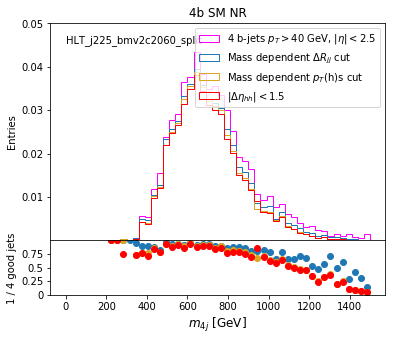

In [58]:
baseFigName='detahh'

mask = miniNtuple.cut_deta_hh #& miniNtuple.tmask
masks.append(mask)
colors.append('red')
labels.append('$|\Delta \eta_{hh}| < 1.5$')

varEvolution(miniNtuple, 'm4j', masks, colors, labels=labels, 
             var_range=m4j_range,xlabel=xlabel, title=title, 
             figDir=figDir, baseFigName=baseFigName,text=triggerText,
             ratio=True,rlabel=rlabel)

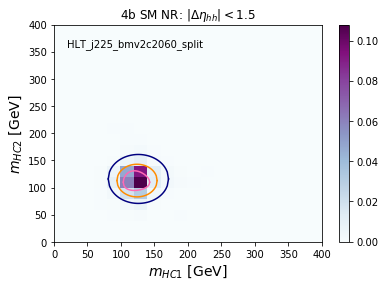

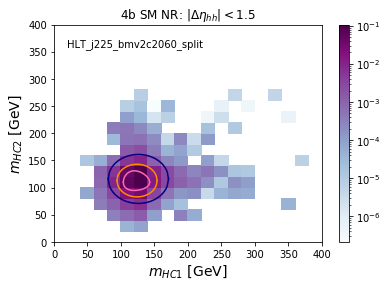

In [59]:
massPlane(miniNtuple.loc[mask,'HC1_m'], 
          miniNtuple.loc[mask,'HC2_m'],
          miniNtuple.loc[mask,'mc_sf'],
          cmap_m, nBins=nBins, varRange=varRange,  
          title=title+': $|\Delta \eta_{hh}| < 1.5$', 
          figDir=figDir, baseFigName=baseFigName, text=triggerText)

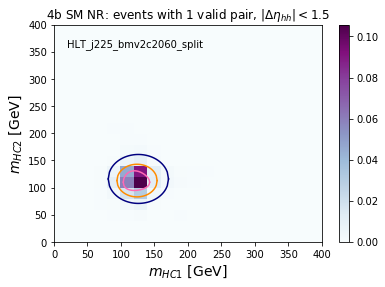

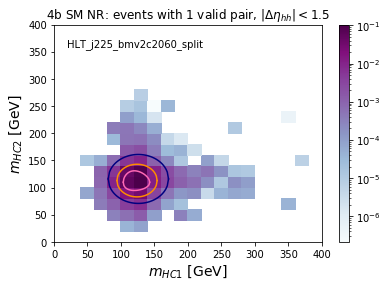

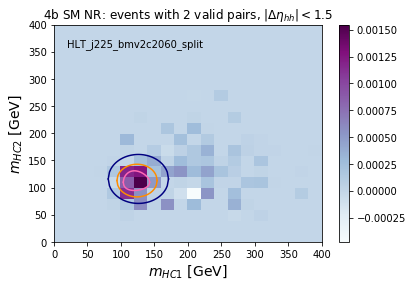

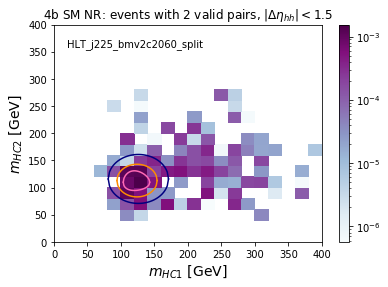

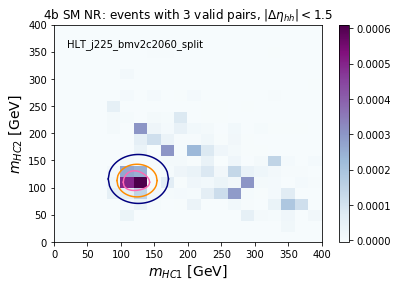

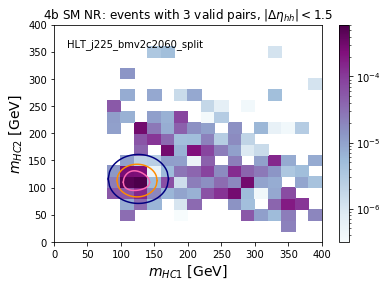

In [60]:
for nPairs in [1,2,3]:
    
    # Get the masses
    mask_pi = mask & (miniNtuple.nValidPairs == nPairs)
    pair_mask = miniNtuple.loc[mask_pi,pair_cols].values
    
    m1_npi = miniNtuple.loc[mask_pi,m1_cols].values
    m2_npi = miniNtuple.loc[mask_pi,m2_cols].values
    
    w_pi = miniNtuple.loc[mask_pi,'mc_sf'].values.reshape(-1,1)*np.ones_like(m1_npi)

    my_title = title + ': events with {} valid pair{}'.format(nPairs,'' if nPairs==1 else 's')
    my_title += ', $|\Delta \eta_{hh}| < 1.5$'
    
    massPlane(m1_npi[pair_mask], m2_npi[pair_mask], w_pi[pair_mask], cmap_m,
              nBins=nBins, varRange=varRange, 
              title=my_title, 
              figDir=figDir, baseFigName=baseFigName,
              tag='_{}validPair'.format(nPairs), 
              text=triggerText)

## Step 6: $X_{wt} < 1.5$

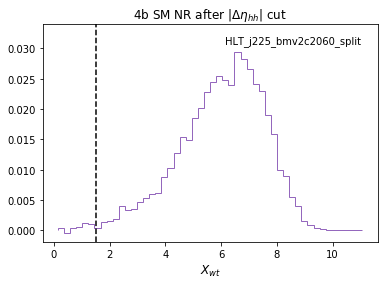

In [61]:
plt.hist(miniNtuple.loc[mask,'Xwt'],50,
         color=c_evt,histtype='step',
         weights=miniNtuple.loc[mask,'mc_sf'])

plt.xlabel('$X_{wt}$',fontsize=12)
plt.title(title+' after $|\Delta \eta_{hh}|$ cut')

ylim = plt.ylim()
plt.plot([1.5,1.5],(ylim[0],1.1*ylim[1]),'k--')
plt.ylim((ylim[0],1.1*ylim[1]))

xlim = plt.xlim()
plt.text(0.95*xlim[1],ylim[1],triggerText,horizontalalignment='right')

plt.savefig('{}/{}_Xwt.pdf'.format(figDir,baseFigName))
plt.show()

In [62]:
baseFigName='Xwt'

mask = miniNtuple.cut_Xwt #& miniNtuple.tmask
masks.append(mask)
colors.append('blue')
labels.append('$X_{wt} > 1.5$')

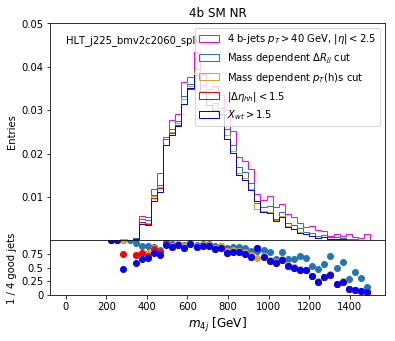

In [63]:
varEvolution(miniNtuple, 'm4j', masks, colors, labels=labels, 
             var_range=m4j_range,xlabel=xlabel, title=title, 
             figDir=figDir, baseFigName=baseFigName,text=triggerText,
             ratio=True,rlabel=rlabel)

It was interesting that this cut was the only one that was preferentially eliminating the *low* $m_{4j}$ values, so we also want to look at how the mass plane plot was impacted in terms of all of the valid pairings.

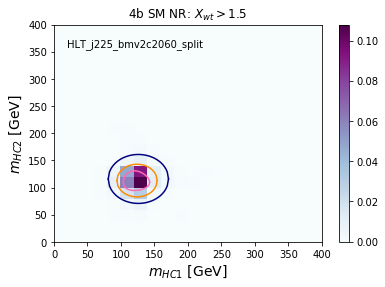

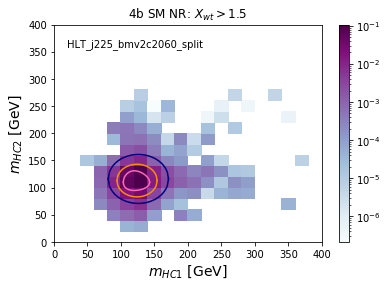

In [64]:
massPlane(miniNtuple.loc[mask,'HC1_m'], 
          miniNtuple.loc[mask,'HC2_m'],
          miniNtuple.loc[mask,'mc_sf'],
          cmap_m, nBins=nBins, varRange=varRange,  
          title=title+': $X_{wt} > 1.5$', 
          figDir=figDir, baseFigName=baseFigName, text=triggerText)

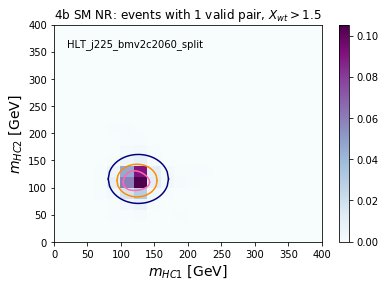

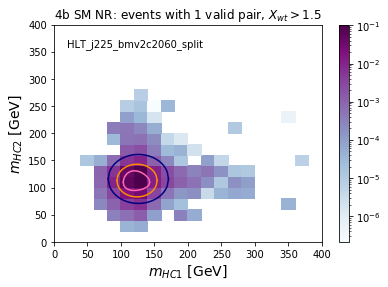

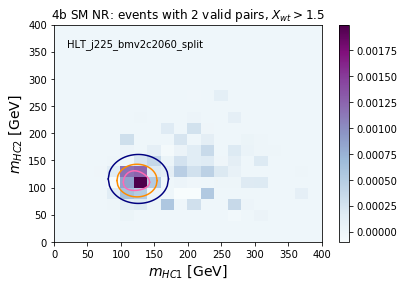

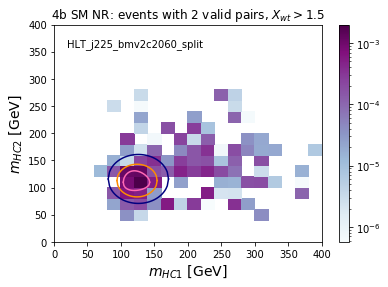

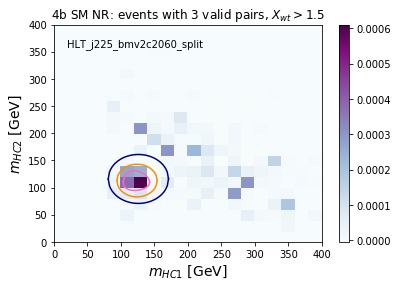

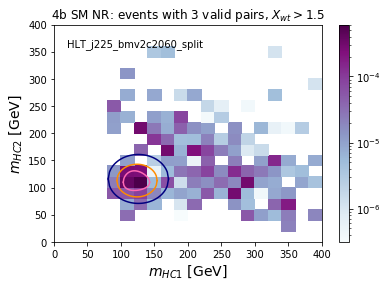

In [65]:
for nPairs in [1,2,3]:
    
    # Get the masses
    mask_pi = mask & (miniNtuple.nValidPairs == nPairs)
    pair_mask = miniNtuple.loc[mask_pi,pair_cols].values
    
    m1_npi = miniNtuple.loc[mask_pi,m1_cols].values
    m2_npi = miniNtuple.loc[mask_pi,m2_cols].values
    
    w_pi = miniNtuple.loc[mask_pi,'mc_sf'].values.reshape(-1,1)*np.ones_like(m1_npi)

    my_title = title + ': events with {} valid pair{}'.format(nPairs,'' if nPairs==1 else 's')
    my_title += ', $X_{wt} > 1.5$'
    
    massPlane(m1_npi[pair_mask], m2_npi[pair_mask], w_pi[pair_mask], cmap_m,
              nBins=nBins, varRange=varRange, 
              title=my_title, 
              figDir=figDir, baseFigName=baseFigName,
              tag='_{}validPair'.format(nPairs), 
              text=triggerText)


## Step 7: Signal region $X_{hh} < 1.6$

I might have to be careful about this if I'm running with data since this is technically unblinding, although 2015 data has already been analyzed. So I should be ok, unless I change the analysis selection.


In [66]:
baseFigName='SR'

mask = miniNtuple.cut_Xhh #& miniNtuple.tmask
masks.append(mask)
colors.append('lime')
labels.append('$X_{hh} < 1.6$')

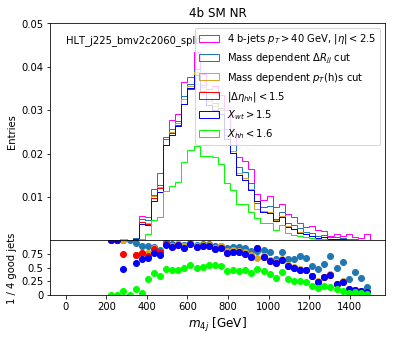

In [67]:
varEvolution(miniNtuple, 'm4j', masks, colors, labels=labels, 
             var_range=m4j_range,xlabel=xlabel, title=title, 
             figDir=figDir, baseFigName=baseFigName,text=triggerText,
             ratio=True,rlabel=rlabel)

Since I've been drawing the full mass plane, there's no reason to repeat it after this cut.

**Sanity check**

I was kind of concerned why there were only 60% of the events making it into the miniNtuple, so Max told me to check this by plotting the mcEventWeight.

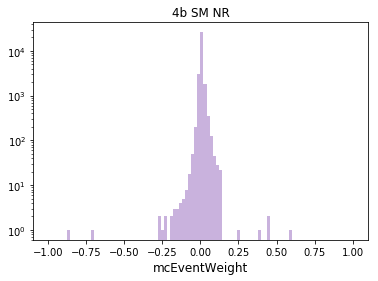

In [68]:
var = 'mcEventWeight'

plt.hist(miniNtuple[var],bins=100,range=(-1,1),
         color=c_evt,alpha=0.5,log=True)
plt.title(title)
plt.xlabel(var,fontsize=12)
plt.savefig('{}/{}.pdf'.format(figDir,var))
plt.show()

In [69]:
'{}/{}.pdf'.format(figDir,var)

'../figures/SMNR_16/HLT_j225_bmv2c2060_split/mcEventWeight.pdf'